In [37]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *
import os
import matplotlib.pyplot as plt 
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

In [38]:
import cv2
count = cv2.cuda.getCudaEnabledDeviceCount()
print(count)

0


In [39]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    suspect = None
    roi = None

    def __init__(self,x, y, width, height, suspect):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.suspect = suspect

In [40]:
class Inspector():
    K = None
    opening = None
    closing = None
    blur = None
    img = None
    c_size = None


    def __init__(self, K, c_size, opening, closing, blur):
        self.K = K
        self.c_size = c_size 
        self.opening = opening
        self.closing = closing
        self.blur = blur

    def setParams(self, K, c_size, opening, closing, blur):
        self.K = K
        self.c_size = c_size 
        self.opening = opening
        self.closing = closing
        self.blur = blur

    def setImg(self, img):
        self.img = img

    def checkParams(self):
        if self.K == None: return False
        if self.opening == None: return False
        if self.closing == None: return False
        if self.closing == None: return False
        return True

    def cluster(self):

        img = cv2.bilateralFilter(self.img,self.blur,75,75)

        Z = img.reshape((-1,3)) 
        Z = np.float32(Z) 
    
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) 
    
        ret,label,center=cv2.kmeans(Z,self.K,None,criteria,attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS) 
        center = np.uint8(center) 
        res = center[label.flatten()] 
        res2 = res.reshape((img.shape)) 
        
        center_n = []

        for i in center:
            center_n.append(i[0])

        empty = np.zeros((img.shape[0], img.shape[1]))
        empty = np.uint8(empty) 

        custerContainer = []
        finalClusters = []

        for i in range(0, len(center_n)):
            empty = np.zeros((img.shape[0], img.shape[1]))
            empty = np.uint8(empty) 
            custerContainer.append(empty)
            
        res2Grey = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
        
        for y in range(0,res2Grey.shape[0]):
            for x in range(0,res2Grey.shape[1]):
                i = center_n.index(res2Grey[y][x])
                custerContainer[i][y][x] = 255

        for img in custerContainer:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.opening,self.opening))
            morph_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
            
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.closing,self.closing))
            morph_img = cv2.morphologyEx(morph_img, cv2.MORPH_CLOSE, kernel)
            
            finalClusters.append(morph_img)
            
        return finalClusters, res2Grey, custerContainer



    def findSuspects(self, clusters):
        p_defects = []

        for img in clusters:
            cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]

            for c in cnts:
                if cv2.contourArea(c) >= self.c_size:
                    p_defects.append(c)
    
        return p_defects
    

    def inspect(self):
        
        clusters, res2Grey, custerContainer = self.cluster()
        suspects = self.findSuspects(clusters)

        tileWidth = 224
        tileHeight = 224
        tiles = []
        
        print("running tiling "+str(len(suspects)))

        for c in suspects:
            print("cluster started " + str(self.c_size))
            x,y,w,h = cv2.boundingRect(c)

            xStart = (int(x/tileWidth) * tileWidth)
            yStart = (int(y/tileHeight) * tileHeight)

            curY = yStart

            while curY < (y+h-1):
                curX = xStart
                while curX < (x+w-1):

                    # dont want tiles to exeed the image 
                    if (curX + tileWidth > img.shape[1]-1):
                        curX = self.img.shape[1]- 1 - tileWidth


                    if (curY + tileHeight > img.shape[0] - 1):
                        curY = self.img.shape[0] - 1 - tileHeight


                    tile = Tile(curX, curY, tileWidth, tileHeight, c)
                    tile.roi = self.img[curY:curY+tileHeight, curX:curX+tileWidth]
                    tiles.append(tile)

                    curX = curX + tileWidth

                curY = curY + tileHeight

        return tiles, img, suspects, clusters

In [41]:
img = cv2.imread("./allCropped/0001_002_00.png")
isp = Inspector(6, 100, 5, 5, 15)
isp.setImg(img)


In [42]:
%%time
tiles, img, suspects, clusters = isp.inspect()

running tiling 2
cluster started 100
cluster started 100
CPU times: total: 5.17 s
Wall time: 2.13 s


2


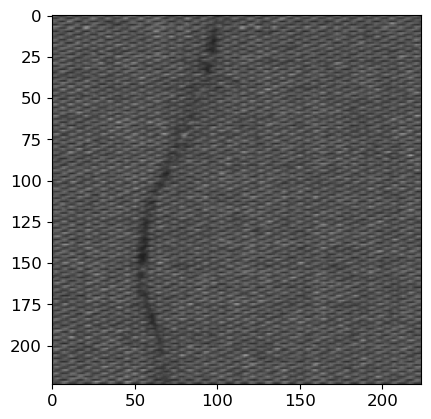

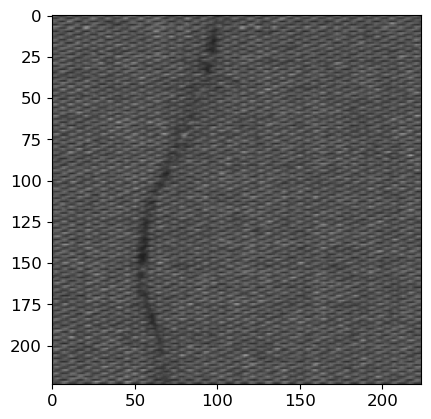

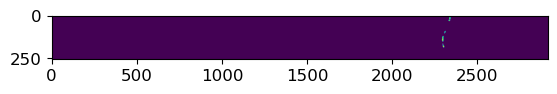

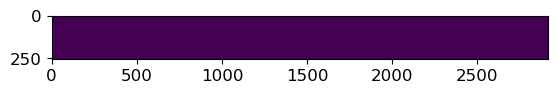

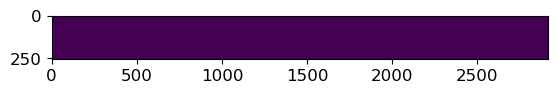

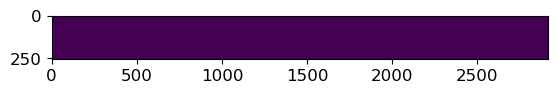

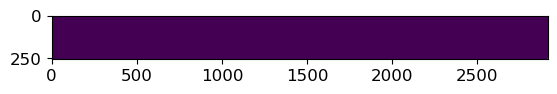

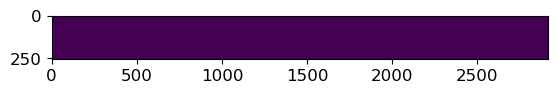

In [43]:
print(len(tiles))

for tile in tiles:
    plt.imshow(tile.roi)
    plt.show()
    
for c in clusters:
    plt.imshow(c)
    plt.show()

# Checking if procedural is faster

In [44]:
# img = cv2.imread("./allCropped/0001_002_00.png")
# blur = 15
# closing = 5
# opening = 5
# K = 6
# c_size = 100



def cluster(img):

    img = cv2.bilateralFilter(img,blur,75,75)

    Z = img.reshape((-1,3)) 
    Z = np.float32(Z) 

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) 

    ret,label,center=cv2.kmeans(Z,K,None,criteria,attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS) 
    center = np.uint8(center) 
    res = center[label.flatten()] 
    res2 = res.reshape((img.shape)) 

    center_n = []

    for i in center:
        center_n.append(i[0])

    empty = np.zeros((img.shape[0], img.shape[1]))
    empty = np.uint8(empty) 

    custerContainer = []
    finalClusters = []

    for i in range(0, len(center_n)):
        empty = np.zeros((img.shape[0], img.shape[1]))
        empty = np.uint8(empty) 
        custerContainer.append(empty)

    res2Grey = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)

    for y in range(0,res2Grey.shape[0]):
        for x in range(0,res2Grey.shape[1]):
            i = center_n.index(res2Grey[y][x])
            custerContainer[i][y][x] = 255

    for img in custerContainer:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (opening,opening))
        morph_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (closing,closing))
        morph_img = cv2.morphologyEx(morph_img, cv2.MORPH_CLOSE, kernel)

        finalClusters.append(morph_img)

    return finalClusters, res2Grey, custerContainer



def findSuspects(clusters):
    p_defects = []

    for img in clusters:
        cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        for c in cnts:
            if cv2.contourArea(c) >= c_size:
                p_defects.append(c)

    return p_defects


def inspect(img):

    clusters, res2Grey, custerContainer = cluster(img)
    suspects = findSuspects(clusters)

    tileWidth = 224
    tileHeight = 224
    tiles = []

    print("running tiling "+str(len(suspects)))

    for c in suspects:
        print("cluster started " + str(c_size))
        x,y,w,h = cv2.boundingRect(c)

        xStart = (int(x/tileWidth) * tileWidth)
        yStart = (int(y/tileHeight) * tileHeight)

        curY = yStart

        while curY < (y+h-1):
            curX = xStart
            while curX < (x+w-1):

                # dont want tiles to exeed the image 
                if (curX + tileWidth > img.shape[1]-1):
                    curX = img.shape[1]- 1 - tileWidth


                if (curY + tileHeight > img.shape[0] - 1):
                    curY = img.shape[0] - 1 - tileHeight


                tile = Tile(curX, curY, tileWidth, tileHeight, c)
                tile.roi = img[curY:curY+tileHeight, curX:curX+tileWidth]
                tiles.append(tile)

                curX = curX + tileWidth

            curY = curY + tileHeight

    return tiles, img, suspects

In [45]:
img = cv2.imread("./allCropped/0001_002_00.png")
blur = 15
closing = 5
opening = 5
K = 6
c_size = 100

In [46]:
%%time
tiles, img, suspects = inspect(img)

## time is the same inside and out of an object

running tiling 2
cluster started 100
cluster started 100
CPU times: total: 4.88 s
Wall time: 1.94 s


# Adding Machine Learning

In [47]:
class CnnInspector(Inspector): 

    model = None

    def __init__(self, K, c_size, model, opening, closing, blur):
        Inspector.__init__(self, K, c_size, opening, closing, blur)
        self.model = model

    def setParams(self, K, c_size, model, opening, closing, blur):
        Inspector.setParams(self, K, c_size, opening, closing, blur)
        self.model = model


    def infer(self, tiles):
        indices = []
        predictions = []
        probailities = []
        
        for i in range(0, len(tiles)):
            pred,pred_idx,probs = self.model.predict(tiles[i].roi)
            if pred == "defect":
                indices.append(i)
                predictions.append(pred)
                probailities.append(probs[pred_idx])
                   
        return indices, predictions, probailities
    

    def inspect(self):
#         defectCnts = []
        defectTiles = []

        tiles, img, suspects, clusters = Inspector.inspect(self)
                
        indices, predictions, probailities = self.infer(tiles)
        
        for i in indices:
#             defectCnts.append(suspects[i])
            defectTiles.append(tiles[i])
            

                
#         return suspects, defectCnts, defectTiles, tiles, predictions, probailities, clusters, img\
        return suspects, defectTiles, tiles, predictions, probailities, clusters, img

In [48]:
def is_defect(x): 
    if x[0]=='d': 
        return 'defect' 
    else:  
        return 'normal'

In [49]:
path = Path('./')
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [50]:
model = load_learner('export.pkl', cpu=True)

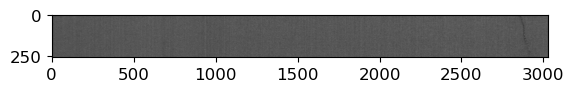

In [51]:
# img = cv2.imread("./allCropped/0001_002_00.png")
img = cv2.imread("./allCropped/0002_002_00.png")
plt.imshow(img)
plt.show()

cnn_isp = CnnInspector(6, 25, model, 5, 5, 15)
cnn_isp.setImg(img)

In [52]:
%%time
# suspects, defectCnts, defectTiles, tiles, predictions, probailities, clusters, img = cnn_isp.inspect()
suspects, defectTiles, tiles, predictions, probailities, clusters, img = cnn_isp.inspect()

running tiling 6
cluster started 25
cluster started 25
cluster started 25
cluster started 25
cluster started 25
cluster started 25


CPU times: total: 6.31 s
Wall time: 2.72 s


In [53]:
print(len(tiles))
print(len(defectTiles))

floatPs = [float(p) for p in probailities]
print(floatPs)

9
9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


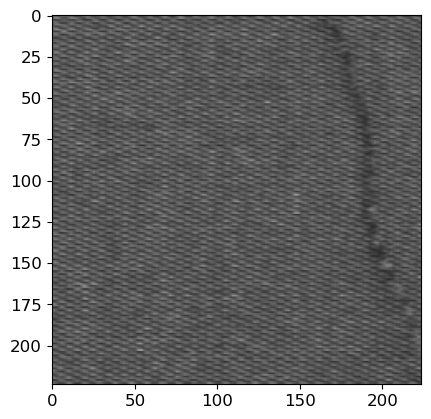

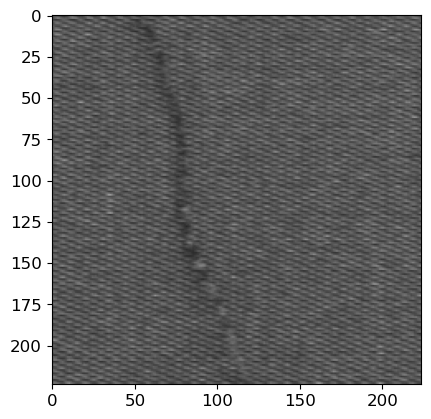

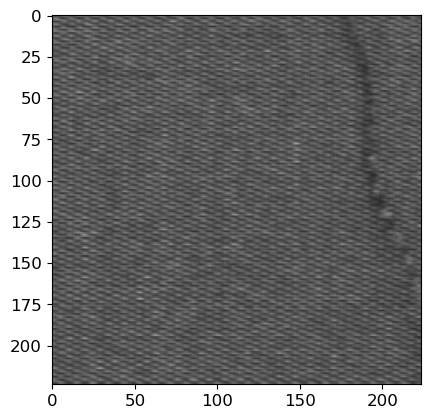

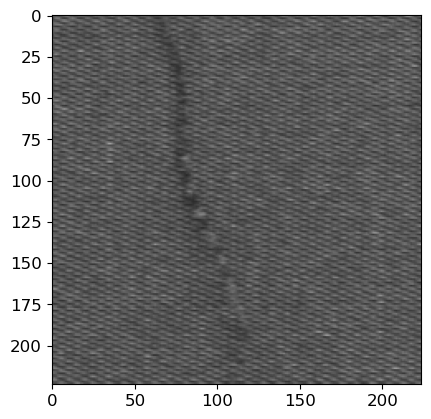

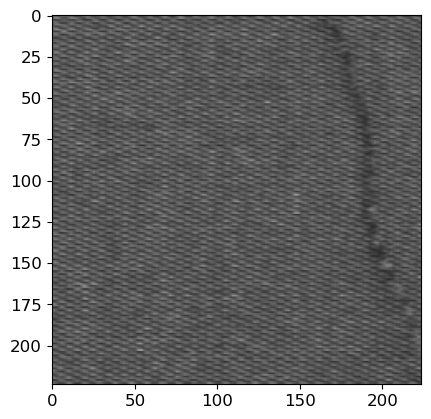

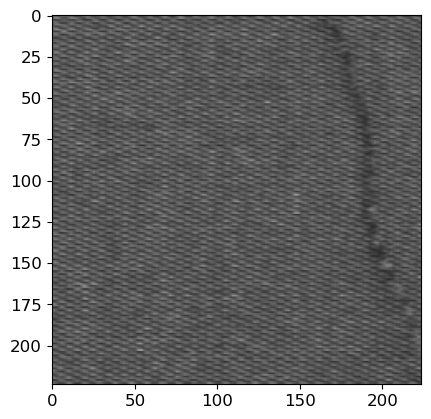

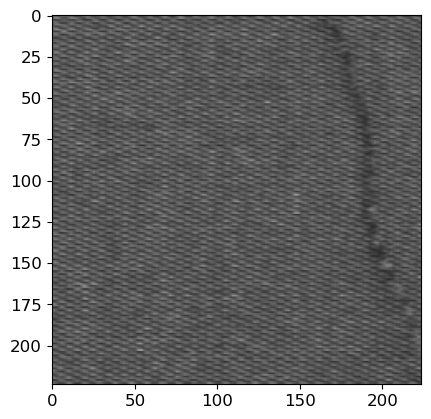

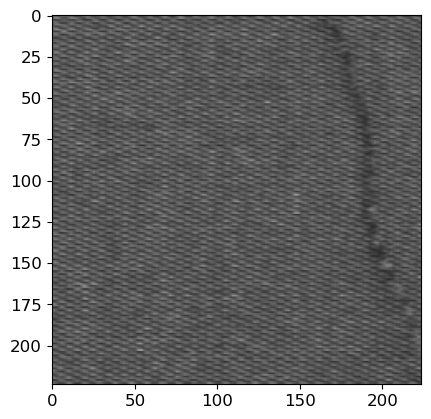

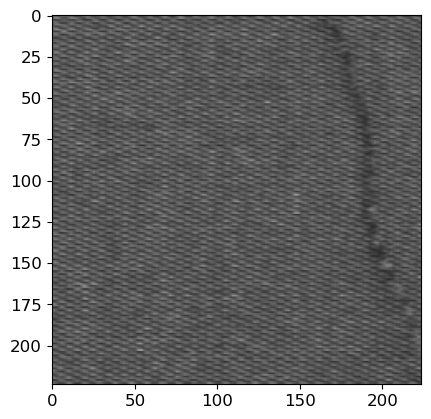

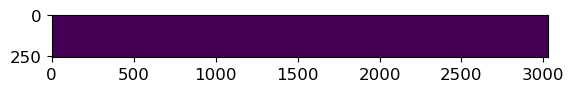

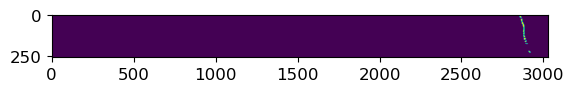

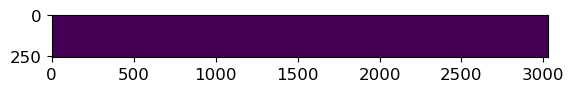

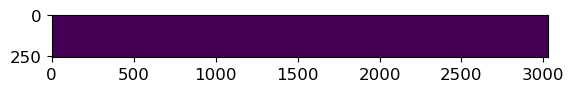

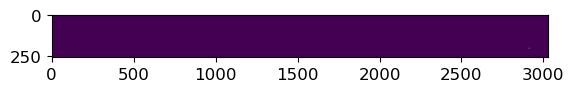

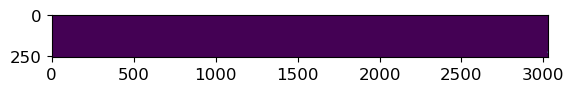

In [54]:
for tile in defectTiles:
    plt.imshow(tile.roi)
    plt.show()

for c in clusters:
    plt.imshow(c)
    plt.show()